In [1]:
import trackhhl.toy.simple_generator as toy
import numpy as np

### Detector Geometry

In [2]:
N_MODULES = 3
LX = float("+inf")
LY = float("+inf")
Z_SPACING = 1.0

detector = toy.SimpleDetectorGeometry(
    module_id=list(range(N_MODULES)),
    lx=[LX]*N_MODULES,
    ly=[LY]*N_MODULES,
    z=[i+Z_SPACING for i in range(N_MODULES)]
)

detector

SimpleDetectorGeometry(module_id=[0, 1, 2], lx=[inf, inf, inf], ly=[inf, inf, inf], z=[1.0, 2.0, 3.0])

### Particle Generator


In [3]:
generator = toy.SimpleGenerator(
    detector_geometry=detector,
    theta_max=np.pi/6
)
generator

SimpleGenerator(detector_geometry=SimpleDetectorGeometry(module_id=[0, 1, 2], lx=[inf, inf, inf], ly=[inf, inf, inf], z=[1.0, 2.0, 3.0]), primary_vertices=[], phi_min=0.0, phi_max=6.283185307179586, theta_min=0.0, theta_max=0.5235987755982988, rng=Generator(PCG64) at 0x27F61C67AE0)

In [4]:
N_PARTICLES = 3
event = generator.generate_event(N_PARTICLES)
event.hits

[Hit(hit_id=0, x=0.011077314363446498, y=0.4362689624334425, z=1.0, module_id=0, track_id=0),
 Hit(hit_id=3, x=-0.07131087958007723, y=-0.1447456978305542, z=1.0, module_id=0, track_id=1),
 Hit(hit_id=6, x=0.1927316193435574, y=0.1639458200041481, z=1.0, module_id=0, track_id=2),
 Hit(hit_id=1, x=0.022154628726892996, y=0.872537924866885, z=2.0, module_id=1, track_id=0),
 Hit(hit_id=4, x=-0.14262175916015446, y=-0.2894913956611084, z=2.0, module_id=1, track_id=1),
 Hit(hit_id=7, x=0.3854632386871148, y=0.3278916400082962, z=2.0, module_id=1, track_id=2),
 Hit(hit_id=2, x=0.03323194309033949, y=1.3088068873003273, z=3.0, module_id=2, track_id=0),
 Hit(hit_id=5, x=-0.2139326387402317, y=-0.4342370934916626, z=3.0, module_id=2, track_id=1),
 Hit(hit_id=8, x=0.5781948580306722, y=0.49183746001244427, z=3.0, module_id=2, track_id=2)]

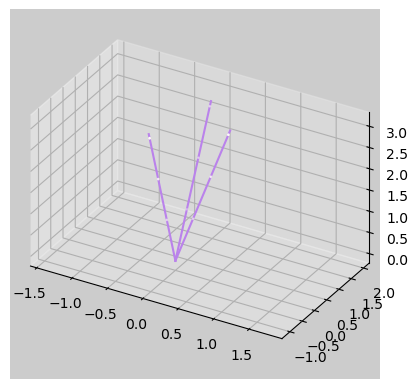

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
event.display(ax)
plt.show()

In [8]:
import numpy as np

events = [np.array([hit.x, hit.y, hit.z]) for hit in event.hits]
N_hits = len(events)
epsilon = 0.01

def H_angular(event_hits, epsilon):
    h_ang = 0
    N_hits = len(event_hits) 

    for a in range(N_hits):
        for b in range(N_hits):
            if a == b or abs(event_hits[b][2] - event_hits[a][2]) != 1:
                continue
            for c in range(N_hits):
                if b == c or a == c:
                    continue
                if abs(event_hits[c][2] - event_hits[b][2]) != 1:
                    continue

                S_ab = event_hits[b] - event_hits[a]
                S_bc = event_hits[c] - event_hits[b]
                length_ab = np.linalg.norm(S_ab)
                length_bc = np.linalg.norm(S_bc)

                if length_ab == 0 or length_bc == 0:
                    continue

                cos_theta_abc = np.dot(S_ab, S_bc) / (length_ab * length_bc)
                if cos_theta_abc >= 1 - epsilon:
                    h_ang -= 0.5  

    return h_ang

def H_bif(event_hits):
    h_bif = 0
    N_hits = len(event_hits)

    for a in range(N_hits):
        z_a = event_hits[a][2]
        
        # possible hits on next layerr z = z_a + 1
        next_layer_hits = []
        for b in range(N_hits):
            if event_hits[b][2] == z_a + 1:
                next_layer_hits.append(b)

        if len(next_layer_hits) <= 1:
            continue
        for b in next_layer_hits:
            z_b = event_hits[b][2]
            next_next_layer_hits = []
            for c in range(N_hits):
                if event_hits[c][2] == z_b + 1:
                    next_next_layer_hits.append(c)

            S_ab = event_hits[b] - event_hits[a]

            # Penalize only if there are multiple possible hits in next layer
            if len(next_next_layer_hits) > 1:
                #penalize based on aligment
                for c in next_next_layer_hits:
                    S_bc = event_hits[c] - event_hits[b]

                    cos_theta_abc = np.dot(S_ab, S_bc) / (np.linalg.norm(S_ab) * np.linalg.norm(S_bc))
                    h_bif -= (1 - cos_theta_abc)  # The closer cos_theta_abc is to 1, the smaller the penalty

    return h_bif



def H_occ(event_hits):
    N_hits = len(event_hits)
    total_sum = 0
    for a in range(N_hits):
        for b in range(N_hits):
            if a == b:
                continue

            S_ab = event_hits[b] - event_hits[a]
            total_sum += np.linalg.norm(S_ab)

    h_occ = 0.5 * (total_sum - N_hits) ** 2

    return h_occ

def HAMILTONIAN(events, epsilon):
    h_angular_value = H_angular(events, epsilon)
    h_bif_value = H_bif(events)
    h_occ_value = H_occ(events)
    return h_angular_value + h_bif_value + h_occ_value

print(f"Hamiltonian (angular term): {H_angular}")
print(f"Hamiltonian (bifurcation term): {H_bif}")
print(f"Hamiltonian (occupancy term): {H_occ}")
print(HAMILTONIAN(events,epsilon))




Hamiltonian (angular term): <function H_angular at 0x0000027F63FCBE20>
Hamiltonian (bifurcation term): <function H_bif at 0x0000027F63FCB420>
Hamiltonian (occupancy term): <function H_occ at 0x0000027F63FCBC40>
4180.1855053620275
